In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import scipy as sp
import IPython.display as ipd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    LSTM,
    TimeDistributed,
    Reshape,
    Input,
)
from tensorflow.keras.optimizers import Adam


In [4]:
# Step 1: Dataset Paths
MEMBO_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/membo_1"  # Folder for Membo drone
BEBOP_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/bebop_1"  # Folder for Bebop drone
NOISE_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/unknown"  # Folder for random noise
DroneA_PATH = "D:/FYP/Final Project/SegmentedAudio"

In [5]:
# Step 2: Helper Functions
def load_audio_files(folder_path, label):
    """Load audio files and associate each with a label."""
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            signal, sr = librosa.load(
                file_path, sr=16000
            )  # Load with fixed sampling rate
            data.append((signal, label))
    return data


# Load datasets
membo_data = load_audio_files(MEMBO_PATH, "membo")
bebop_data = load_audio_files(BEBOP_PATH, "bebop")
noise_data = load_audio_files(NOISE_PATH, "noise")
droneA_data = load_audio_files(DroneA_PATH, "droneA")

In [6]:
# Combine and shuffle data
data = membo_data + bebop_data + noise_data + droneA_data
np.random.shuffle(data)


# Step 3: Feature Extraction
def extract_features(signal, sr=16000, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1)  # Averaging over time for traditional ML models


features = []
labels = []

for signal, label in data:
    mfcc_features = extract_features(signal)
    features.append(mfcc_features)
    labels.append(label)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(


In [7]:
# Step 5: CNN Model for Audio Spectrograms
def prepare_cnn_data():
    cnn_features = []
    cnn_labels = []
    max_mfcc_length = 40  # Ensure all MFCC arrays have the same time dimension
    
    for signal, label in data:
        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=13)
        
        # Pad or truncate the features to the fixed length
        if mfcc_features.shape[1] < max_mfcc_length:
            # Pad if shorter
            padding = max_mfcc_length - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, padding)), mode='constant')
        else:
            # Truncate if longer
            mfcc_features = mfcc_features[:, :max_mfcc_length]
        
        # Expand dimensions for CNN input
        cnn_features.append(np.expand_dims(mfcc_features, axis=-1))
        cnn_labels.append(label)
        
    return np.array(cnn_features), to_categorical(label_encoder.transform(cnn_labels))


cnn_features, cnn_labels = prepare_cnn_data()
X_train, X_test, y_train, y_test = train_test_split(
    cnn_features, cnn_labels, test_size=0.2, random_state=42
)

cnn_model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            input_shape=(cnn_features.shape[1], cnn_features.shape[2], 1),
        ),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
cnn_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test)
)
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")


d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8376 - loss: 1.8194 - val_accuracy: 0.9348 - val_loss: 0.2370
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9262 - loss: 0.2269 - val_accuracy: 0.9501 - val_loss: 0.1691
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9455 - loss: 0.1685 - val_accuracy: 0.9572 - val_loss: 0.1104
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9589 - loss: 0.1229 - val_accuracy: 0.9668 - val_loss: 0.1171
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9649 - loss: 0.1075 - val_accuracy: 0.9639 - val_loss: 0.1033
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9709 - loss: 0.0900 - val_accuracy: 0.9801 - val_loss: 0.0546
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9714 - loss: 0.0815 - val_accuracy: 0.9838 - val_loss: 0.0516
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9713 - loss: 0.0786 - val_acc

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


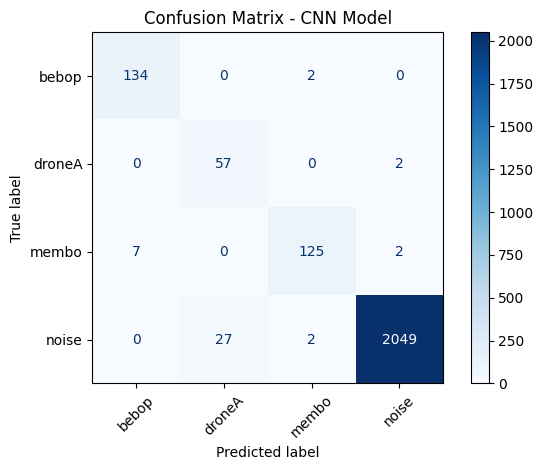

In [8]:
# Step 1: Make predictions on the test set
y_pred_probs = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = label_encoder.classes_

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - CNN Model")
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get predicted class indices
y_pred_probs = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Step 2: Get true class indices
y_true_classes = np.argmax(y_test, axis=1)

# Step 3: Get class labels
class_labels = label_encoder.classes_

# Step 4: Print full classification report
print("📊 Classification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_labels
))


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
📊 Classification Report:
              precision    recall  f1-score   support

       bebop       0.95      0.99      0.97       136
      droneA       0.68      0.97      0.80        59
       membo       0.97      0.93      0.95       134
       noise       1.00      0.99      0.99      2078

    accuracy                           0.98      2407
   macro avg       0.90      0.97      0.93      2407
weighted avg       0.99      0.98      0.98      2407



76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


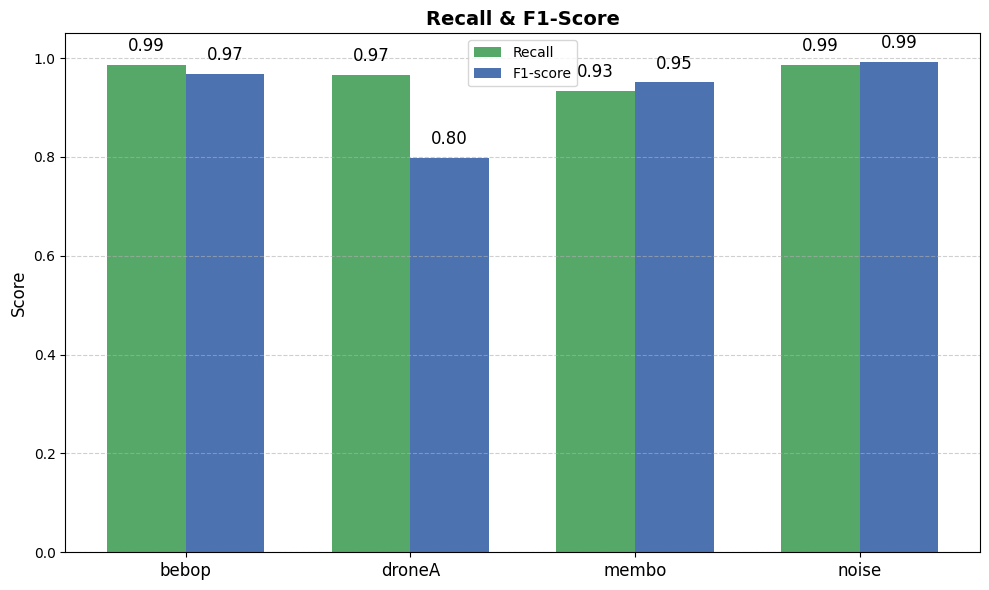

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Step 1: Predict
y_pred_probs = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
class_labels = label_encoder.classes_

# Step 2: Generate classification report
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_labels,
    output_dict=True
)

# Step 3: Extract only F1-score and Recall
metrics = ["recall", "f1-score"]
data = {metric: [report[label][metric] for label in class_labels] for metric in metrics}
x = np.arange(len(class_labels))  # Class positions

# Aesthetics
bar_width = 0.35
colors = ['#55a868', '#4c72b0']  # Green for recall, blue for F1

# Plot
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    offset = (i - 0.5) * bar_width
    plt.bar(
        x + offset,
        data[metric],
        width=bar_width,
        label=metric.capitalize(),
        color=colors[i]
    )
    # Value labels
    for xi, val in zip(x + offset, data[metric]):
        plt.text(xi, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=12)

plt.xticks(x, class_labels,fontsize=12)
plt.ylim(0, 1.05)
plt.ylabel("Score",fontsize=12)
plt.title("Recall & F1-Score", fontsize=14, weight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# after cnn_model.fit(...)
cnn_model.save('cnn_model.h5')
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [11]:
import queue
import sounddevice as sd
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model
from collections import deque

# ───────── CONFIG ─────────
MODEL_PATH = 'cnn_model.h5'
LABEL_ENCODER_PATH = 'label_encoder.pkl'

DEVICE_INDEX = 12        # UMIK-1 fixed device index
UMIK_SR = 48000          # Mic sampling rate
TARGET_SR = 16000        # Model training rate
DURATION = 1.0           # Window length (seconds)
STEP = 0.5               # Time between predictions (seconds)

N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
MAX_MFCC_LENGTH = 40     # Pad/truncate MFCC frames

SMOOTHING_WINDOW = 5     # Rolling average over last N predictions
ALERT_THRESHOLD = 0.7    # Alert threshold for DroneA detection
# ─────────────────────────

# Load model and label encoder
model = load_model(MODEL_PATH)
label_encoder = joblib.load(LABEL_ENCODER_PATH)
classes = label_encoder.classes_
drone_idx = list(classes).index('droneA')

# Buffers
audio_queue = queue.Queue()
buffer = deque(maxlen=int(UMIK_SR * DURATION))
p_history = deque(maxlen=SMOOTHING_WINDOW)
alert_triggered = False

# MFCC extraction
def extract_mfcc_window(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    if mfcc.shape[1] < MAX_MFCC_LENGTH:
        pad = MAX_MFCC_LENGTH - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_MFCC_LENGTH]
    return mfcc

# Audio input callback
def audio_callback(indata, frames, time, status):
    if status:
        print("⚠️", status)
    audio_queue.put(indata[:, 0].copy())

# Main loop
def main():
    print(f"\n🎧 Starting stream on UMIK-1 (device index {DEVICE_INDEX})...")
    with sd.InputStream(
        samplerate=UMIK_SR,
        device=DEVICE_INDEX,
        channels=1,
        blocksize=int(UMIK_SR * STEP),
        callback=audio_callback
    ):
        print("🛸 Listening for DroneA... (press Ctrl+C to stop)")
        try:
            while True:
                block = audio_queue.get()
                buffer.extend(block)

                if len(buffer) < UMIK_SR * DURATION:
                    continue

                y48 = np.array(buffer)
                y16 = librosa.resample(y48, orig_sr=UMIK_SR, target_sr=TARGET_SR)
                mfcc = extract_mfcc_window(y16, TARGET_SR)
                X = mfcc[np.newaxis, :, :, np.newaxis]

                probs = model.predict(X, verbose=0)[0]
                p_drone = probs[drone_idx]
                p_history.append(p_drone)

                avg_p = np.mean(p_history)

                if avg_p > ALERT_THRESHOLD and not alert_triggered:
                    print(f"\n🚨 ALERT: DroneA detected! Avg Probability: {avg_p:.3f}")
                    alert_triggered = True
                elif avg_p <= ALERT_THRESHOLD:
                    alert_triggered = False

                print(f"DroneA probability (avg): {avg_p:.3f}", end='\r')

        except KeyboardInterrupt:
            print("\n🛑 Stream stopped.")

if __name__ == '__main__':
    main()



🎧 Starting stream on UMIK-1 (device index 12)...
🛸 Listening for DroneA... (press Ctrl+C to stop)
DroneA probability (avg): 0.039
🛑 Stream stopped.
